# Torch Paper Replication
### Checking for the right torch and torchvision versions

In [1]:
try:
    import torch
    import torchvision
    assert(int(torch.__version__.split('.')[0]) >= 2 or int(torch.__version__.split(".")[1]) >= 12, "torch version must be greater than 1.12")
    assert(int(torchvision.__version__.split(".")[1]) >= 13, "torch version must be greater than 0.13")
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

<>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/tmp/ipykernel_6136/2401564698.py:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(int(torch.__version__.split('.')[0]) >= 2 or int(torch.__version__.split(".")[1]) >= 12, "torch version must be greater than 1.12")
/tmp/ipykernel_6136/2401564698.py:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(int(torchvision.__version__.split(".")[1]) >= 13, "torch version must be greater than 0.13")


torch version: 2.1.1+cu121
torchvision version: 0.16.1+cu121


### Importing the requried libraries

In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn 
from torchvision import transforms

from torchinfo import summary

from modular_version import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

/home/umer/umer_projects/torch_tutor/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Setting up the device agnostic code

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get Data

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Create Datasets and DataLoaders
#### Prepare transforms for images

In [6]:
# Create image size (from table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


### Turn images into `DataLoader`'s

In [7]:
# BATCH_SIZE_VIT = 4096
BATCH_SIZE = 32 # this is lower than the VIT paper so as to avoid our hardware any sort of issues, as my hardware isnt that capable

# Create data loaders 
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7473241fb940>,
 ['pizza', 'steak', 'sushi'])

### Visualize a Single Image

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

(-0.5, 223.5, 223.5, -0.5)

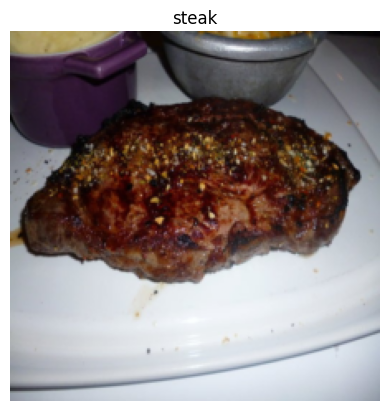

In [9]:
# Plot the image using Matplotlib
plt.imshow(image.permute(1,2,0)) # rearrange image dimensions to suit the matplotlib (H, W, Color_Channels)
plt.title(class_names[label])
plt.axis(False)

## Replicating the ViT Paper
### Inputs and outputs, layers and blocks

* Layer - takes an input, performs a function on it, returns an output.
* Block - a collection of layers, takes an input, performs a series of functions on it, returns an output.
* Architecture (or model) - a collection of blocks, takes an input, performs a series of functions on it, returns an output.

The ViT architecture is comprised of several stages:

* **Patch + Position Embedding (inputs)** - Turns the input image into a sequence of image patches and adds a position number to specify in what order the patch comes in.
* **Linear projection of flattened patches (Embedded Patches)** - The image patches get turned into an **embedding**, the benefit of using an embedding rather than just the image values is that an embedding is a learnable representation (typically in the form of a vector) of the image that can improve with training.
* **Norm** - This is short for "Layer Normalization" or "LayerNorm", a technique for regularizing (reducing overfitting) a neural network, you can use LayerNorm via the PyTorch layer `torch.nn.LayerNorm()`.
* **Multi-Head Attention** - This is a Multi-Headed Self-Attention layer or "MSA" for short. You can create an MSA layer via the PyTorch layer `torch.nn.MultiheadAttention()`.
* **MLP** (or Multilayer perceptron) - A MLP can often refer to any collection of feedforward layers (or in PyTorch's case, a collection of layers with a `forward()` method). In the ViT Paper, the authors refer to the MLP as "MLP block" and it contains two `torch.nn.Linear()` layers with a `torch.nn.GELU()` non-linearity activation in between them (section 3.1) and a `torch.nn.Dropout()` layer after each.
* **Transformer Encoder** - The Transformer Encoder, is a collection of the layers listed above. There are two skip connections inside the Transformer encoder (the "+" symbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of a number of Transformer encoders stacked on top of eachother.
* **MLP Head** - This is the output layer of the architecture, it converts the learned features of an input to a class output. Since we're working on image classification, you could also call this the "classifier head". The structure of the MLP Head is similar to the MLP block.

### Calculating patch embedding input and output shapes by hand

In [10]:
# Creating example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculating N (number of patches)
number_of_patches = int((height*width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [11]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# output shape
embedding_layer_output_shape = (number_of_patches, (patch_size**2 * color_channels))

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


### Turning the Image into Patches

(-0.5, 223.5, 223.5, -0.5)

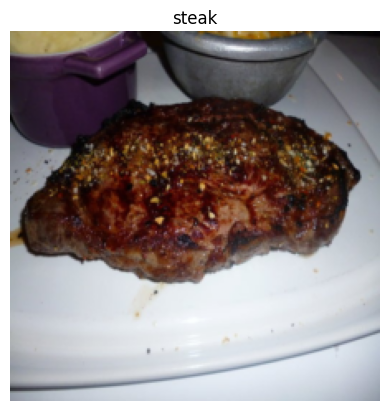

In [12]:
# View single image
plt.imshow(image.permute(1,2,0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False)

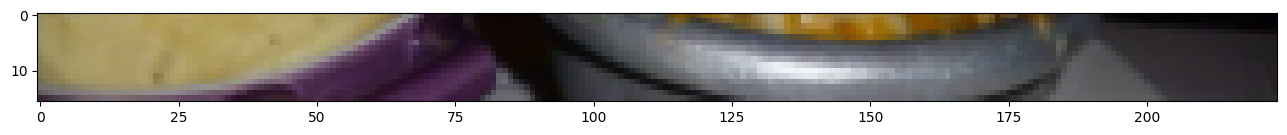

In [13]:
# Permuted image to be compatible with matplotlib
image_permuted = image.permute(1,2,0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


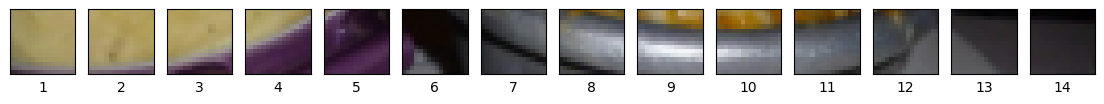

In [14]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size neet to be divisible by the patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots to display all the patches
fig, axs = plt.subplots(nrows=1,
                         ncols=img_size // patch_size, # One column per patch
                         figsize=(num_patches, num_patches),
                         sharex=True,
                         sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Now let's do this for the whole image

Number of patches per row: 14.0      
Number of patches per column: 14.0      
Total patches: 196.0      
Patch size: 16 pixels x 16 pixels


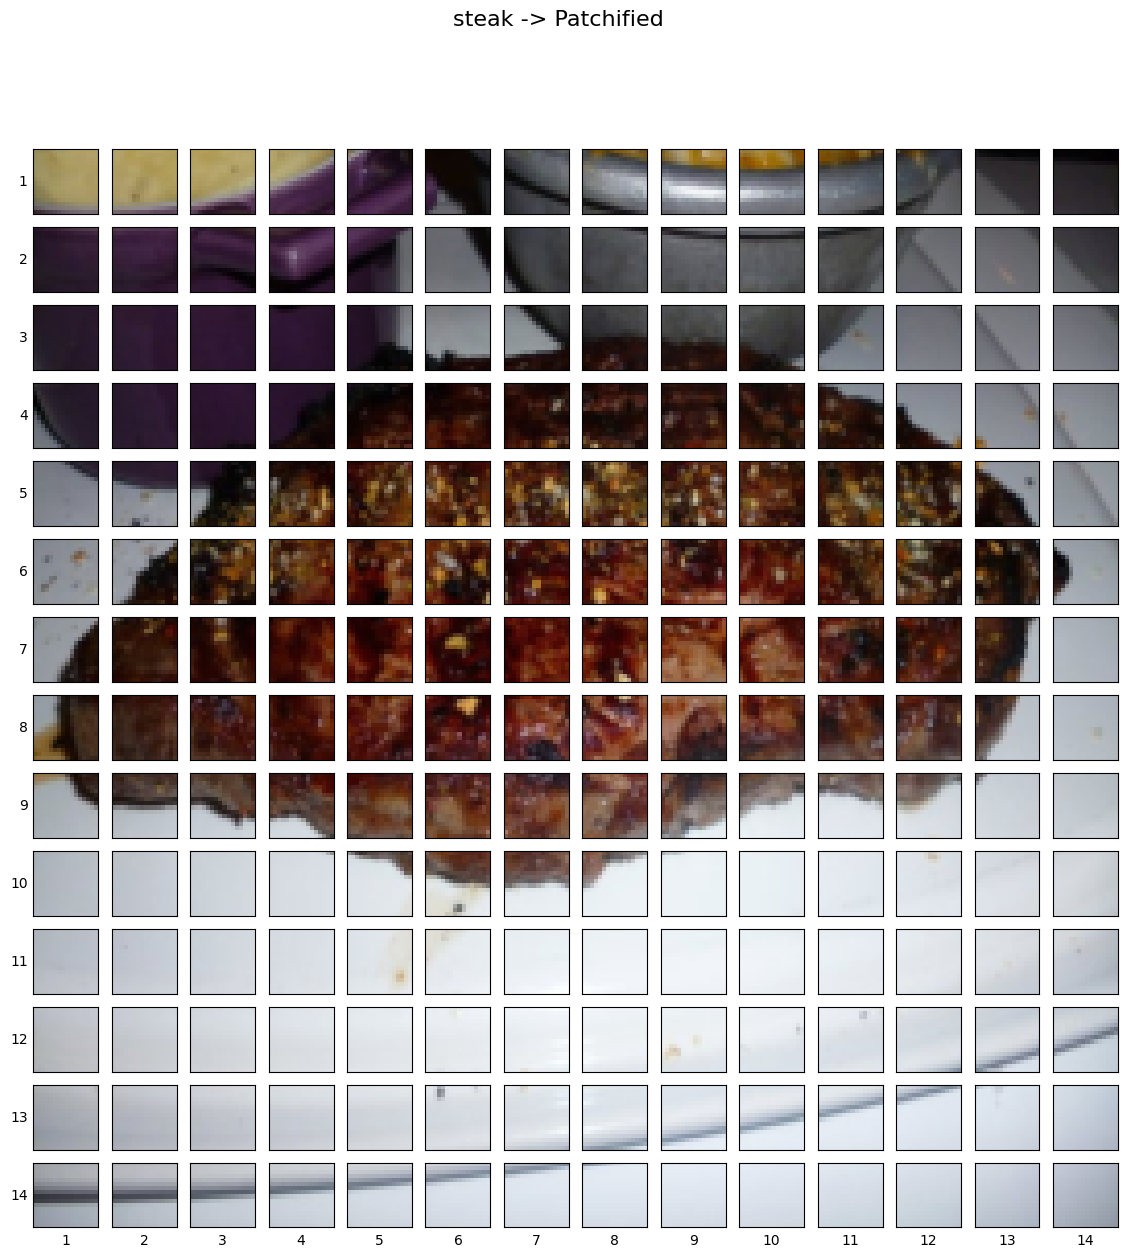

In [15]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size neet to be divisible by the patch size"
print(f"Number of patches per row: {num_patches}\
      \nNumber of patches per column: {num_patches}\
      \nTotal patches: {num_patches*num_patches}\
      \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots to display all the patches
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                         ncols=img_size // patch_size, # One column per patch
                         figsize=(num_patches, num_patches),
                         sharex=True,
                         sharey=True)

# Loop through height and width of the image
for i, patch_height in enumerate(range(0, img_size, patch_size)):
      for j, patch_width in enumerate(range(0, img_size, patch_size)):

            # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
            axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                            patch_width:patch_width+patch_size, # iterate through width
                                            :]) # get all color channels
            
            # Set up label information, remove the ticks for clarity and set labels to outside
            axs[i, j].set_ylabel(i+1,
                                 rotation="horizontal",
                                 horizontalalignment="right",
                                 verticalalignment="center")
            axs[i, j].set_xlabel(j+1)
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

### Creating image patches with `torch.nn.Conv2d()`

In [16]:
from torch import nn 

# Set the patch size
patch_size=16

# Create the Conv2D layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # Hidden size D, this is the embedding size
                   kernel_size=patch_size, # this is equivalent to (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

(-0.5, 223.5, 223.5, -0.5)

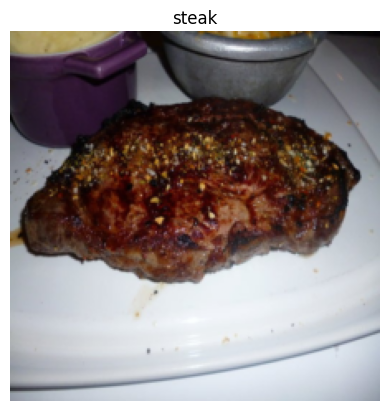

In [17]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False)

In [18]:
# Pass the image through the convolution layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [581, 523, 360, 249, 265]


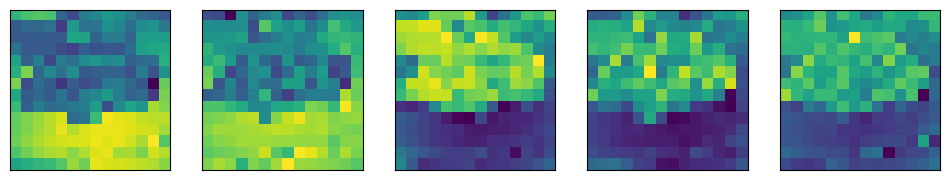

In [19]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 768), k=5) # pick 5 numbers between 0 and embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

The important thing to note is that these features may change over time as the neural network learns.

And because of these, these feature maps can be considered a learnable embedding of our image.

In [20]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.0229, -0.0112, -0.0406,  0.1403,  0.0408, -0.0034,  0.0051,
           -0.1202, -0.1251, -0.1561, -0.0810, -0.0317, -0.0182, -0.0183],
          [-0.0106,  0.0223,  0.0595, -0.0178, -0.1081, -0.0380,  0.0213,
           -0.0090, -0.0798, -0.0109, -0.0503, -0.0507, -0.0321, -0.0167],
          [-0.0159, -0.0052, -0.0052, -0.0158, -0.0164, -0.0442,  0.0577,
            0.0550,  0.0711, -0.0190, -0.1235, -0.0547, -0.0836, -0.0491],
          [-0.0168, -0.0131,  0.0071,  0.0394,  0.0574,  0.0231,  0.0894,
            0.0574,  0.0299,  0.0070,  0.1382, -0.0021, -0.0559, -0.0435],
          [-0.1036, -0.1462,  0.0356, -0.0123, -0.0738,  0.0761, -0.0070,
            0.0887,  0.0928,  0.0462,  0.0342, -0.0304, -0.0134, -0.0724],
          [-0.0723,  0.1282,  0.0413,  0.0822,  0.0023, -0.0387,  0.0887,
            0.0279, -0.0366,  0.0688,  0.0216, -0.0256, -0.0112, -0.1020],
          [ 0.0856,  0.0669,  0.0574,  0.0232, -0.0112,  0.0674,  0.0310,
            0.0124, -0.0049,  0.

### Flattening the patch embedding with `torch.nn.Flatten()`

How do we get them into the desired output shape of the patch embedding layer of the ViT model?

**Desired output (1D sequence of flattened 2D patches):** (196, 768) -> (number of patches, embedding dimension) -> N×(P2⋅C)
Let's check the current shape.

In [21]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [22]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


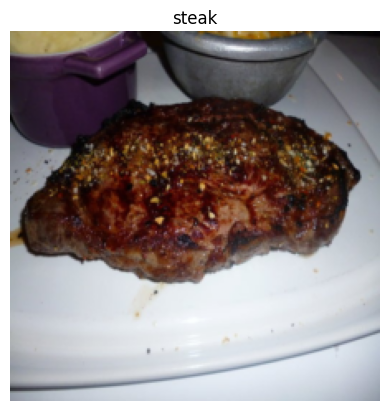

In [23]:
# View single image
plt.imshow(image.permute(1,2,0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Turn the image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

It looks like our `image_out_of_conv_flattened` shape is very close to our desired output shape:

- **Desired output (flattened 2D patches)**: (196, 768) -> N×(P2⋅C)

- **Current shape:** (1, 768, 196)

In [24]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


(-0.5, 195.5, 0.5, -0.5)

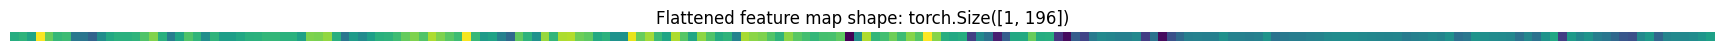

In [25]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:,:,0]

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)

In [26]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad

(tensor([[-0.0229, -0.0112, -0.0406,  0.1403,  0.0408, -0.0034,  0.0051, -0.1202,
          -0.1251, -0.1561, -0.0810, -0.0317, -0.0182, -0.0183, -0.0106,  0.0223,
           0.0595, -0.0178, -0.1081, -0.0380,  0.0213, -0.0090, -0.0798, -0.0109,
          -0.0503, -0.0507, -0.0321, -0.0167, -0.0159, -0.0052, -0.0052, -0.0158,
          -0.0164, -0.0442,  0.0577,  0.0550,  0.0711, -0.0190, -0.1235, -0.0547,
          -0.0836, -0.0491, -0.0168, -0.0131,  0.0071,  0.0394,  0.0574,  0.0231,
           0.0894,  0.0574,  0.0299,  0.0070,  0.1382, -0.0021, -0.0559, -0.0435,
          -0.1036, -0.1462,  0.0356, -0.0123, -0.0738,  0.0761, -0.0070,  0.0887,
           0.0928,  0.0462,  0.0342, -0.0304, -0.0134, -0.0724, -0.0723,  0.1282,
           0.0413,  0.0822,  0.0023, -0.0387,  0.0887,  0.0279, -0.0366,  0.0688,
           0.0216, -0.0256, -0.0112, -0.1020,  0.0856,  0.0669,  0.0574,  0.0232,
          -0.0112,  0.0674,  0.0310,  0.0124, -0.0049,  0.0130,  0.0157,  0.0342,
          -0.296

### Turning the VIT patch embedding layer into a PyTorch Module
We can do so by subclassing `nn.Module` and creating a small PyTorch "model" to do all of the steps above.

Specifically we will:

- Create a class called `PatchEmbedding` which subclasses `nn.Module` (so it can be used a PyTorch layer).
- Initialize the class with the parameters in_channels=3, patch_size=16 (for ViT-Base) and embedding_dim=768 (this is D for ViT-Base from Table 1).
- Create a layer to turn an image into patches using `nn.Conv2d()`.
- Create a layer to flatten the patch feature maps into a single dimension.
- Define a `forward()` method to take an input and pass it through the layers created in 3 and 4.
- Make sure the output shape reflects the required output shape of the ViT architecture (N×(P2⋅C)).

In [28]:
# Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """
    Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """

    # Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
    
        #  Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
    
        # Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, #only flatten the feature map dimensions into a single vector.
                                  end_dim=3)
    
    #  Define the forward method
    def forward(self, x):
        # Create assertion to check the inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        
        # Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]    

In [29]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])
